## <center>Concepts of Data Science - Group Project</center>
### <center>Implementation and Benchmarking of a Bloom Filter</center>
#### <center>Karina Bule-Flori, Matteo Ramina</center>

### 1 Introduction

In this Jupyter notebook, we integrate both object-oriented and procedural programming techniques to implement, benchmark, and test a Bloom filter. As outlined by Tarkoma, Rothenberg, and Lagerspetz (2011), a Bloom filter is a space-efficient probabilistic data structure that may produce false positives (incorrectly indicating that an element is in the set when it is not) but never false negatives (failing to identify an element that is in the set). Essentially, a Bloom filter is an array of $m$ bits representing a set $S = {x_1, x_2, ..., x_n}$ of $n$ elements, which are initialized as zero. The underlying concept is to map items $x \in S$ to random numbers uniformly distributed in the range $1, ..., m$ using $k$ hash functions, denoted as $h_i(x), 1 \leq i \leq k$.

Our Bloom filter takes as inputs $n$, the size of the set $S$, and the desired false positive probability $p \in [0, 1]$. In turn, the size of the bit array is computed as:
$$m = - \frac{n ln(p)}{[ln(2)]^2}$$

While the number of hash functions is determined by:
$$k = \frac{m}{n}ln(2)$$

We will benchmark and test the Bloom filter through simulations. Specifically, the Bloom filter is designed to store file names generated by the auxiliary function *generate_random_strings*, which creates random strings representing file names that can range from 1 to 255 characters. This upper limit was chosen because it is the maximum file name length in Windows and macOS. We will simulate the creation of names and evaluate the Bloom filter’s characteristics, such as the false positive rate, insertion time, and query time, using these simulated names.

Reference: Tarkoma, S., Rothenberg, C. E., & Lagerspetz, E. (2011). Theory and practice of bloom filters for distributed systems. *IEEE Communications Surveys & Tutorials, 14*(1), 131-155.

### 2 Implementation

The bloom filter has been implemented with the following characteristics:

- It calculates $m$ and $k$ dynamically based on the number of items expected and the desired false positive probability.

- It includes an *add* function to insert items in the bloom filter, as well as a *check* function to look up values stored in the bloom filter.

- It allows to retrieve information regarding the bloom filter such as the size of the bit array via the function *generate_stats*.

- It can clear the content of the bloom filter through the function *clear*, which is particularly important for simulation purposes.

```python

class BloomFilter:
    """
    Class for bloom filter, using murmur3 hash function
    """

    def __init__(self, n, p):
        """
        n : int
            Number of items expected to be stored in Bloom filter
        p : float
            Desired false positive rate
        """
        self.n = n
        self.p = p

        self.m = math.ceil(-n * math.log(p) / (math.log(2) ** 2))
        self.k = math.ceil((self.m / n) * math.log(2))

        self.bit_array = bitarray(self.m)
        self.bit_array.setall(0)

    def _hashes(self, item):
        """
        Generates k hash values for the given item
        """
        return [mmh3.hash(item, i) % self.m for i in range(self.k)]

    def add(self, item):
        """
        Insert an element to the filter
        """
        for hash_val in self._hashes(item):
            self.bit_array[hash_val] = 1

    def check(self, item):
        """
        Returns boolean whether element exists in the set or not
        """
        return all(self.bit_array[hash_val] for hash_val in self._hashes(item))

    def generate_stats(self):
        """
        Calculates and returns the statistics of a filter
        Probability of FP, n, m, k, predicted false positive rate.
        """
        n = float(self.n)
        m = float(self.m)
        k = float(self.k)
        p_fp = float(self.p)
        print("Predicted false positive rate: ", p_fp * 100.0)
        print("Number of elements expected in filter: ", n)
        print("Number of bits in filter: ", m)
        print("Number of hashes in filter: ", k)

    def clear(self):
        """
        Reinitializes the filter and clears old values and statistics
        """
        self.bit_array.setall(0)

```

### 3 Benchmarking

#### 3.1 Performance

To benchmark our Bloom filter's performance in maintaining a 5% false positive prediction rate, we conducted a series of simulations. The function *test_performance* evaluates the Bloom filter's efficacy by using a provided list of file names, which is randomly divided into names that will be added into the filter and names that will not. The Bloom filter is then tested to determine its false positive rate.

Each simulation begins by clearing the Bloom filter and shuffling the name list. A subset of the file names is added into the filter, while the remaining names are used to test for false positives by looking them up. By repeating this process 100 times (as specified by *sim_num*) for each sample size, we gather an average false positive rate across simulations. This average provides an empirical measure of the filter's performance relative to the target false positive rate of 5%.

To visually represent the results, we employed the *generate_graph* function.

Two main benchmarking scenarios were considered: one with a fixed Bloom filter size and another with a dynamically adjusting filter size based on the input set size.

```python

from bloomf import BloomFilter2
from random import choices, randint, seed
import string
from typing import List
import matplotlib.pyplot as plt

seed(1010)

def generate_random_strings(size: int, min_length: int, max_length: int) -> List[str]:
    word_list = []
    for _ in range(size):
        word = ''.join(choices(string.ascii_letters, k=randint(min_length, max_length)))
        word_list.append(word)
    return word_list

def test_performance(bloom_filter: BloomFilter, probability: float, words_list: List[str], sim_num: int) -> float:
    
    false_positive_rate = []

    for _ in range(sim_num):

        num_elements_to_add = int(probability * len(words_list))
        elements_to_add = words_list[:num_elements_to_add]

        for element in elements_to_add:
            bloom_filter.add(element)

        test_words = words_list

        false_positives = 0
        for word in test_words:

            if bloom_filter.check(word) and word not in elements_to_add:
                false_positives += 1

        false_positive_rate.append(false_positives / (len(test_words) - num_elements_to_add))

    false_positive_rate_average = sum(false_positive_rate)/len(false_positive_rate)
        
    return false_positive_rate_average

def generate_graph(data):

    sample_sizes = [entry['sample_size'] for entry in data]
    false_positive_rates = [entry['false_positive_rate'] for entry in data]

    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.2
    index = range(len(data))
    ax.bar(index, false_positive_rates, width=bar_width, label='False Positive Rate')

    ax.set_xlabel('Sample Size')
    ax.set_ylabel('False Positive Rate')
    ax.set_title('False Positive Rates for Different Sample Sizes and Array Sizes')
    step = len(sample_sizes) // 4
    ax.set_xticks(index[::step])
    ax.set_xticklabels(sample_sizes[::step], rotation=45)
    ax.axhline(y=0.05, color='r', linestyle='--', linewidth=1, label='Target 5% FPR')
    ax.legend()

    plt.tight_layout()
    fig.savefig('chart_1_false_positive_rates.png')
    plt.show()

if __name__ == "__main__":

    array_size = 9585058
    hash_functions = 7
    probability = 0.05
    min_char = 1
    max_char = 255
    sample_min = 10
    sample_max = 10000
    sample_step = 10

    bloom_filter = BloomFilter2(array_size, hash_functions)

    results = []
    n = 10
    sim = 100

    for i in range(sample_min, sample_max, sample_step):

        words_list = generate_random_strings(i, min_char, max_char)
        
        false_positive_rate = test_performance(bloom_filter, probability, words_list, sim)

        results.append({'sample_size': i, 'false_positive_rate': false_positive_rate})

        generate_graph(results)

```

In both scenarios, as shown in the graphs below, the Bloom filter consistently maintained a false positive rate that was mostly near the target of 5%, demonstrating its robustness and efficiency.

The first graph illustrates the performance of a fixed Bloom filter initialized with an expected capacity of 10,000 items. It reveals that with smaller lists of file names, the false positive rate remains notably below 5%. However, as the sample size approaches the expected capacity, the rate gradually approaches the 5% threshold.

In contrast, the second graph showcases the performance of a dynamically adjusted Bloom filter. Initially, this graph suggests potentially more fluctuating results for smaller sample sizes of file name lists. However, as the sample sizes increase, the Bloom filter quickly stabilizes and converges towards the desired 5% false positive rate.

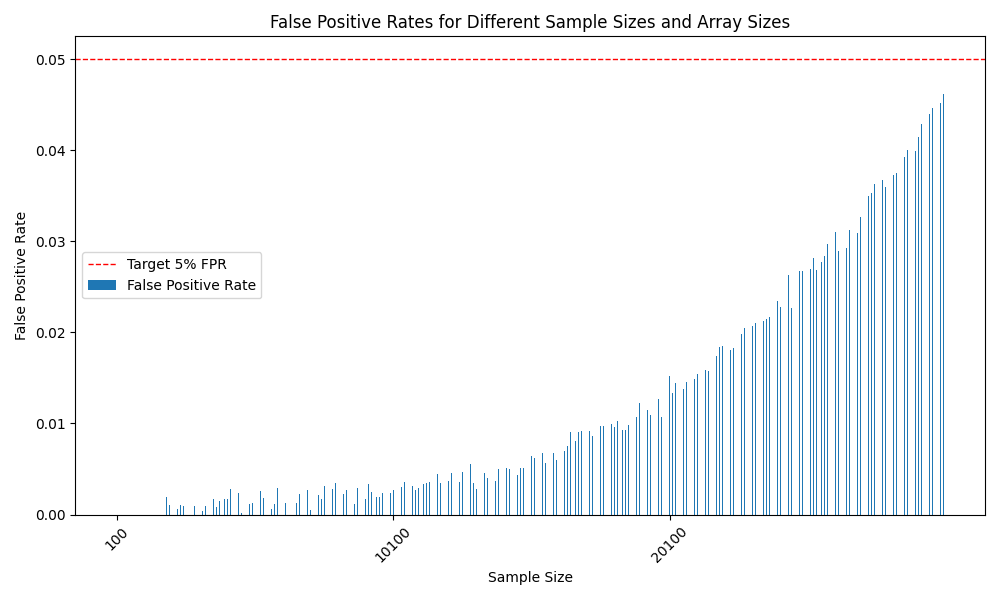

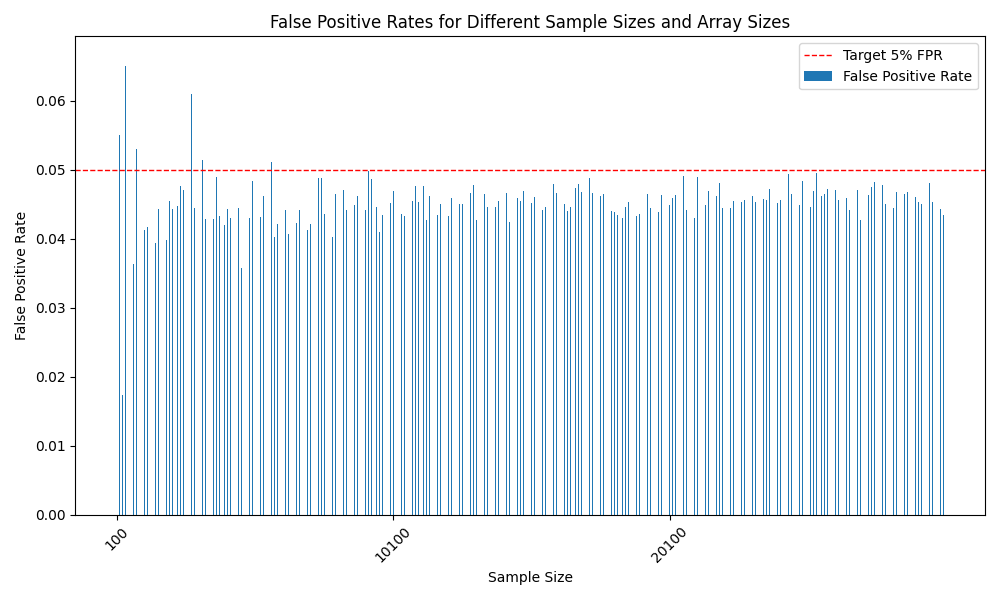

In [2]:
from IPython.display import Image, display

display(Image(filename='chart_1_fixed_bf.png'))
display(Image(filename='chart_1_dynamic_bf.png'))

#### 3.2 Theoretical Complexity

##### 3.2.1 Adding

The BloomFilter2 class utilizes hash functions to efficiently add and check for elements in the Bloom filter. When adding an element (*add* method), the algorithm computes hash values using $k$ hash functions, where $k$ is determined by the size of the filter relative to the expected number of elements $n$ and the desired false positive rate $p$. The time complexity for adding an element is:
$$O(k)$$

##### 3.2.2 Checking

Similar to the *add* method, when checking for the presence of an element (*check* method), the algorithm computes hash values using the same $k$ hash functions and checks if all corresponding bits in the bit array are set. This operation also has a time complexity of: $$O(k)$$

#### 3.3 Empirical Complexity

The empirical complexity of the adding and checking of the Bloom filter has been executed using the function below. More specifically, the function *test_add_check* evaluates the performance of the Bloom filter by measuring the time taken to add elements and check their membership across multiple simulations.

During each simulation, the function tracks the time taken to add each individual word (*item_add_time*) and the total time taken for all additions (*total_add_time*). For each word in the words_list, the *add* method of the Bloom filter is called, and the time taken is recorded. Subsequently, the function measures the time to check each individual word (*item_check_time*) and the total time for all checks (*total_check_time*). For each word in the words_list, the *check* method of the Bloom filter is executed, and the time taken is recorded.

After completing all simulations, the function computes the average time per element for both the *add* and *check* operations across all simulations. This is achieved by dividing the total time by the number of elements processed.

As in the false positive rate benchmarking, this is performed for both a fixed Bloom filter and a dynamically adjusted Bloom filter.

```python

def test_add_check(bloom_filter: BloomFilter2, words_list: List[str], sim_num: int) -> Tuple[float, float, float, float]:
    
    item_add_time = []
    total_add_time = []
    item_check_time = []
    total_check_time = []

    for _ in range(sim_num):

        start_add_time = time.time_ns()
        
        for item in words_list:
            start_add_time_elem = time.time_ns()
            bloom_filter.add(item)
            end_add_time_elem = time.time_ns()
            item_add_time.append(end_add_time_elem - start_add_time_elem)
        
        end_add_time = time.time_ns()
        total_add_time.append(end_add_time - start_add_time)

        start_check_time = time.time_ns()

        for item in words_list:
            start_check_time_elem = time.time_ns()
            bloom_filter.check(item)
            end_check_time_elem = time.time_ns()
            item_check_time.append(end_check_time_elem - start_check_time_elem)            
        
        end_check_time = time.time_ns()
        total_check_time.append(end_check_time - start_check_time)

    item_add_time_average = sum(item_add_time) / (sim_num * len(words_list))
    total_add_time_average = sum(total_add_time)/sim_num

    item_check_time_average = sum(item_check_time) / (sim_num * len(words_list))
    total_check_time_average = sum(total_check_time)/sim_num

    return item_add_time_average, total_add_time_average, item_check_time_average, total_check_time_average

if __name__ == "__main__":

    seed(1010)
    n = 1000
    p = 0.05
    min_char = 1
    max_char = 255
    samples = [1000, 10000]
    sim_num = 100

    bloom_filter = BloomFilter2(n, p)
    results = []

    for i in samples:

        words_list = generate_random_strings(i, min_char, max_char)
        
        item_add_time_average, total_add_time_average, item_check_time_average, total_check_time_average = test_add_check(bloom_filter, words_list, sim_num)

        results.append({'sample_size': i, 'item_add_time': item_add_time_average / 1e6, 'total_add_time': total_add_time_average / 1e6,
                        'item_check_time': item_check_time_average / 1e6, 'total_check_time': total_check_time_average / 1e6})

    for i, _ in enumerate(results):
        print(f'Times for {results[i]["sample_size"]} items | Add: {round(results[i]["total_add_time"], 6)} ms | Check: {round(results[i]["total_check_time"], 6)} ms')

    item_add_time_weighted_average_num = 0
    item_add_time_weighted_average_denom = 0
    item_check_time_weighted_average_num = 0
    item_check_time_weighted_average_denom = 0
    
    for i, _ in enumerate(results):
        item_add_time_weighted_average_num = item_add_time_weighted_average_num + results[i]["sample_size"] * results[i]["item_add_time"]
        item_add_time_weighted_average_denom = item_add_time_weighted_average_num + results[i]["sample_size"]
        item_check_time_weighted_average_num = item_check_time_weighted_average_num + results[i]["sample_size"] * results[i]["item_check_time"]
        item_check_time_weighted_average_denom = item_check_time_weighted_average_num + results[i]["sample_size"]
    
    print(f'\nAverage add time per element is {round(item_add_time_weighted_average_num / item_add_time_weighted_average_denom, 6)} ms\nAverage check time per element is {round(item_check_time_weighted_average_num / item_check_time_weighted_average_denom, 6)} ms')

if __name__ == "__main__":

    seed(1010)
    n = 1000
    p = 0.05
    min_char = 1
    max_char = 255
    samples = [1000, 10000]
    sim_num = 100

    results = []

    for i in samples:

        bloom_filter = BloomFilter2(i, p)

        words_list = generate_random_strings(i, min_char, max_char)
        
        item_add_time_average, total_add_time_average, item_check_time_average, total_check_time_average = test_add_check(bloom_filter, words_list, sim_num)

        results.append({'sample_size': i, 'item_add_time': item_add_time_average / 1e6, 'total_add_time': total_add_time_average / 1e6,
                        'item_check_time': item_check_time_average / 1e6, 'total_check_time': total_check_time_average / 1e6})

    for i, _ in enumerate(results):
        print(f'Times for {results[i]["sample_size"]} items | Add: {round(results[i]["total_add_time"], 6)} ms | Check: {round(results[i]["total_check_time"], 6)} ms')

    item_add_time_weighted_average_num = 0
    item_add_time_weighted_average_denom = 0
    item_check_time_weighted_average_num = 0
    item_check_time_weighted_average_denom = 0
    
    for i, _ in enumerate(results):
        item_add_time_weighted_average_num = item_add_time_weighted_average_num + results[i]["sample_size"] * results[i]["item_add_time"]
        item_add_time_weighted_average_denom = item_add_time_weighted_average_num + results[i]["sample_size"]
        item_check_time_weighted_average_num = item_check_time_weighted_average_num + results[i]["sample_size"] * results[i]["item_check_time"]
        item_check_time_weighted_average_denom = item_check_time_weighted_average_num + results[i]["sample_size"]
    
    print(f'\nAverage add time per element is {round(item_add_time_weighted_average_num / item_add_time_weighted_average_denom, 6)} ms\nAverage check time per element is {round(item_check_time_weighted_average_num / item_check_time_weighted_average_denom, 6)} ms')

```

##### 3.3.1 Adding

The results below demonstrate efficient performance of both the fixed and dynamically adjusted Bloom filters across various dataset sizes. Adding 1,000 items averaged between 3.20 ms and 3.68 ms, while adding 10,000 items averaged between 29.68 ms and 29.82 ms. The average time to add each element was consistent, approximating 0.003 ms for both filters.

##### 3.3.2 Checking

At the same time, the empirical results indicate comparable performance between the fixed and dynamically adjusted filters for checking operations. Checking 1,000 items ranged between 3.55 ms and 3.62 ms, while checking 10,000 items averaged between 33.62 ms and 34.50 ms. The average checking time per element was also similar, approximating 0.0035 ms for both filters.